# DAD for Wave by Triplet Loss

## Settings

In [1]:
from pathlib import Path
import sys

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics

import torch
from torchvision import transforms

In [3]:
sys.path.append('../src')

import utils
from dataloader import ESC50Dataset, ESC50DatasetTriplet
from models import EmbeddingNet, TripletNet
from loss_functions import TripletLoss

In [4]:
no_cuda = True
seed = 0

In [5]:
data_dir = Path().cwd().parent/'data'
raw_data_dir = data_dir/'external'/'ESC-50'
processed_data_dir = data_dir/'processed'/'ESC-50'
models_dir = Path().cwd().parent/'models'

In [6]:
model_path = models_dir/'model_best.pth'
#embeddingnet_path = models_dir/'embeddingnet_best.pth'
embeddingnet_path = models_dir/'embeddingnet_best_m04.pth'

In [7]:
metadata_path = raw_data_dir/'meta'/'esc50.csv'
audio_dir = raw_data_dir/'audio'
spectrogram_dir = processed_data_dir/'spectrogram'

In [8]:
train_metadata_path = processed_data_dir/'metadata_train.csv'
valid_metadata_path = processed_data_dir/'metadata_valid.csv'
test_metadata_path = processed_data_dir/'metadata_test.csv'

In [38]:
np.random.seed(0)

In [9]:
use_cuda = torch.cuda.is_available() and (not no_cuda)
device = 'cuda' if use_cuda else 'cpu'
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = True

print('device: {}'.format(device))

device: cpu


In [10]:
class ESC50DatasetTest(ESC50Dataset):
    def __init__(self, metadata_path, audio_dir, spectrogram_dir, transform=None,):
        super(ESC50DatasetTest, self).__init__(metadata_path, audio_dir, spectrogram_dir, transform)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        spec, label = self.load_spectrogram(index), self.load_label(index)
        if self.transform is not None:
            spec = self.transform(spec)
        return spec, label

In [11]:
def evaluate_bc(y_true, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    acc = metrics.accuracy_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)

    print('Acc: {:.4f}  Precision: {:.4f}  Recall: {:.4f}  F1: {:4f}'.format(acc, prec, recall, f1))
    print('Confusion Matrix')
    print(confusion_matrix)

In [12]:
def evaluate_auc(labels, scores):
    fpr, tpr, _ = metrics.roc_curve(labels, scores)
    auc = metrics.auc(fpr, tpr)

    plt.title('ROC curve (AUC = {:.2f})'.format(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

## Hyperparameters

In [13]:
input_size = (257, 431)
output_size = 128

## Dataloader

In [14]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

In [16]:
dataset_test = ESC50DatasetTest(
    test_metadata_path, audio_dir, spectrogram_dir, transform,
    )

In [17]:
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, **kwargs)

## Model

In [18]:
embedding_net = EmbeddingNet(input_size, output_size).to(device)
embedding_net.eval()
embedding_net.load_state_dict(torch.load(str(embeddingnet_path)))

### Test

In [19]:
dataset_test.labels

{2, 24, 28, 34, 40}

In [20]:
label_ref = 40
n_ref = 30

In [21]:
indices_ref_all = dataset_test.label2indices[label_ref]
_indices_ref = np.random.permutation(range(len(indices_ref_all)))[:n_ref]
indices_ref = np.array(indices_ref_all)[_indices_ref]

In [22]:
embeddings_ref = []
embeddings = []
labels = []

for index, (spec, label) in enumerate(dataloader_test):
    print('\rIndex {}'.format(index), end='')
    embedding = embedding_net(spec).cpu().detach().numpy().flatten()
    if index in indices_ref:
        embeddings_ref.append(embedding)
    else:
        embeddings.append(embedding)
        raw_label = label.cpu().detach().numpy()[0]
        used_label = 1 if (raw_label == label_ref) else -1
        labels.append(used_label)
embeddings_ref = np.array(embeddings_ref)
embeddings = np.array(embeddings)

Index 199

## Threshold

In [42]:
n_test = len(labels)
scores = []
for i in range(n_test):
    embedding = embeddings[i]
    label = labels[i]
    dists = np.sum((embedding[np.newaxis, :] - embeddings_ref)**2, axis=1)
    score = dists.mean()
    scores.append(score)
    print('label {}    Score: {}'.format(label, score))

label -1    Score: 0.030182307586073875
label -1    Score: 0.027133697643876076
label -1    Score: 0.029728107154369354
label -1    Score: 0.02792331948876381
label -1    Score: 0.025864947587251663
label -1    Score: 0.026170941069722176
label -1    Score: 0.03554757684469223
label -1    Score: 0.02860270068049431
label -1    Score: 0.026230426505208015
label -1    Score: 0.028551911935210228
label -1    Score: 0.032385990023612976
label -1    Score: 0.03795165568590164
label -1    Score: 0.027183016762137413
label -1    Score: 0.029435016214847565
label -1    Score: 0.03310113400220871
label -1    Score: 0.027247345075011253
label -1    Score: 0.17367354035377502
label -1    Score: 0.02910737134516239
label -1    Score: 0.144181489944458
label -1    Score: 0.0883764699101448
label -1    Score: 0.11599066853523254
label -1    Score: 0.0695265680551529
label -1    Score: 0.10651468485593796
label -1    Score: 0.11239566653966904
label -1    Score: 0.03509260341525078
label -1    Score:

In [43]:
preds = [1 if (score < 0.05) else -1 for score in scores]

In [44]:
evaluate_bc(labels, preds)

Acc: 0.7647  Precision: 0.1429  Recall: 0.6000  F1: 0.230769
Confusion Matrix
[[124  36]
 [  4   6]]


In [45]:
score_max, score_min = max(scores), min(scores)
#scores_n = [(score-score_min)/(score_max-score_min) for score in scores]
scores_n = [-score for score in scores]

In [46]:
fpr, tpr, _ = metrics.roc_curve(labels, scores_n)
auc = metrics.auc(fpr, tpr)
print('AUC: {:.4f}'.format(auc))

AUC: 0.7831


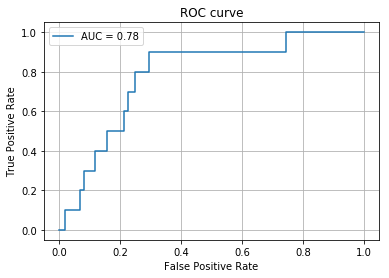

In [47]:
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

## Test by LOF

In [30]:
clf = LocalOutlierFactor(
    n_neighbors=1,
    novelty=True,
    contamination='auto',
    )

In [31]:
clf.fit(embeddings_ref)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=None,
          n_neighbors=1, novelty=True, p=2)

In [32]:
preds = clf.predict(embeddings)

In [33]:
evaluate_bc(labels, preds)

Acc: 0.6235  Precision: 0.1250  Recall: 0.9000  F1: 0.219512
Confusion Matrix
[[97 63]
 [ 1  9]]


In [34]:
scores = clf.score_samples(embeddings)

In [35]:
fpr, tpr, _ = metrics.roc_curve(labels, scores)
auc = metrics.auc(fpr, tpr)
print('AUC: {:.4f}'.format(auc))

AUC: 0.8556


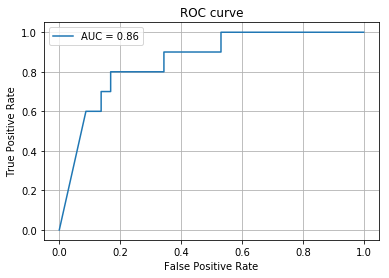

In [36]:
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()